In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
from utils import gen_random, gen_almost_one, gen_arithmetic, gen_geometric

def truncate_eigenvalues(eigs, t):
    """
    Sort eigenvalues in descending order, keep the top t,
    and renormalize them to sum=1. The rest are effectively zero.
    Returns an array of length t.
    """
    sorted_eigs = np.sort(eigs)[::-1]  # descending
    truncated = sorted_eigs[:t]
    truncated /= np.sum(truncated)
    return truncated

In [12]:
def newton_girard_predict(traces, k):
    """
    Given:
      - traces: a list [Tr(rho^1), Tr(rho^2), ..., Tr(rho^r)]
      - k: the exponent for which we want Tr(rho^k)
    Uses Newton-Girard formulas to compute Tr(rho^k).
    
    Returns:
      Tr(rho^k) as a float.
    """
    r = len(traces)
    if k <= r:
        return traces[k-1]
    sums = [0]*(k+1)
    sums[0] = 1.0
    for i in range(1, r+1):
        sums[i] = traces[i-1]

    a = [0]*(r+1)
    a[0] = 1.0
    a[1] = sums[1]  # = Tr(rho^1)
    
    for i in range(2, r+1):
        temp = 0.0
        for j in range(1, i+1):
            temp += ((-1)**(j-1)) * a[i-j] * sums[j]
        a[i] = temp / i
    
    for m in range(r+1, k+1):
        tmp = 0.0
        for j in range(1, r+1):
            tmp += ((-1)**(j-1)) * sums[m-j] * a[j]
        sums[m] = tmp
    
    return sums[k] # sums[k] = Tr(rho^k)

In [13]:
r = 8
t = 6
k = 16

eigs = gen_almost_one(r)
traces = [sum(eigs ** i) for i in range(1, r + 1)]
truncate_traces = traces[:t]

print(newton_girard_predict(traces, k))          # P_k
print(newton_girard_predict(truncate_traces, k)) # P_k'

2.842170943040401e-14
-4.596358849084936e-09


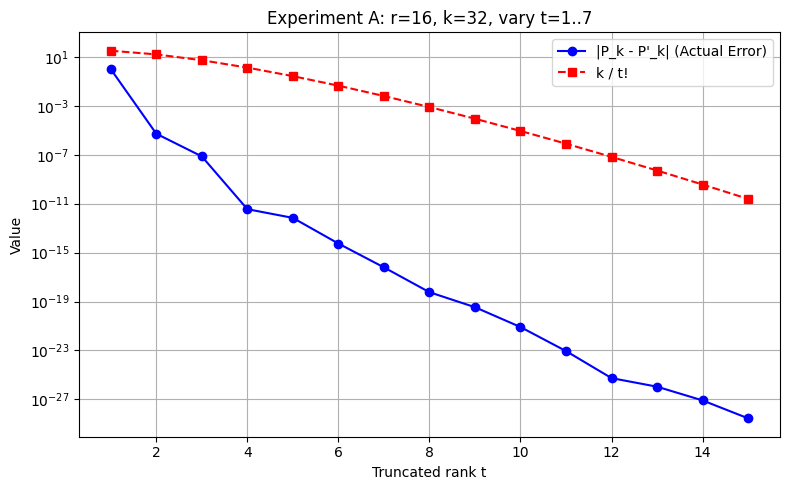

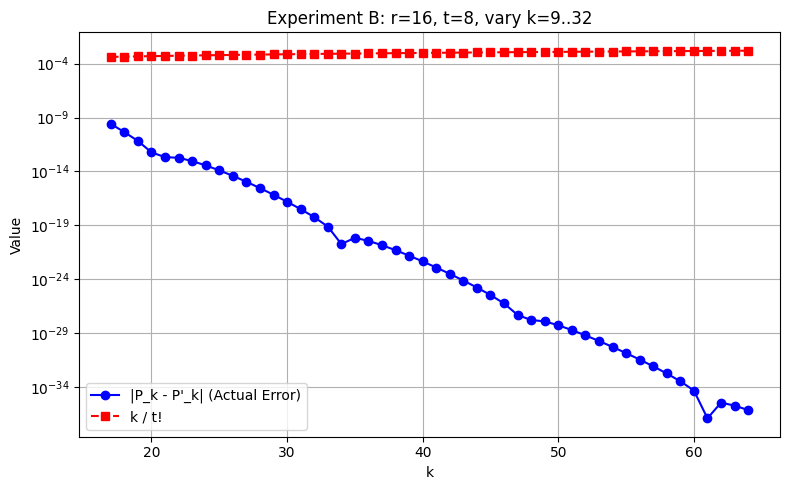

In [14]:
# Fix random seed for reproducibility
np.random.seed(42)

# 1) Generate an actual rank-r=16 eigenvalue vector
r = 16
eigs = gen_almost_one(r)
# Full (true) traces up to r=16
full_traces = [np.sum(eigs**i) for i in range(1, r+1)]

# =========================
# Experiment A
# =========================
# Fix k=32, vary t=1..15
k_A = 32
t_vals_A = range(1, r)  # 1..15
errors_A = []
bounds_A = []

# First, the "true" Tr(rho^k) using rank=8 info
P_k_full = newton_girard_predict(full_traces, k_A)

for t in t_vals_A:
    # Truncated power sums
    truncated_traces = full_traces[:t]
    # Estimated Tr(rho^k)
    P_k_trunc = newton_girard_predict(truncated_traces, k_A)
    err = abs(P_k_full - P_k_trunc)
    errors_A.append(err)
    
    # Bound = k / t!
    fac_t = math.factorial(t)
    bound_val = k_A / fac_t
    bounds_A.append(bound_val)

# Plot for Experiment A
plt.figure(figsize=(8,5))
plt.plot(t_vals_A, errors_A, 'bo-', label="|P_k - P'_k| (Actual Error)")
plt.plot(t_vals_A, bounds_A, 'rs--', label="k / t!")
plt.xlabel("Truncated rank t")
plt.ylabel("Value")
plt.yscale('log')
plt.title(f"Experiment A: r={r}, k={k_A}, vary t=1..7")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Experiment B
# =========================
# Fix t=8, vary k=17...64
t_B = 8
k_vals_B = range(17, 65)  # 17...64
errors_B = []
bounds_B = []

# Truncated traces
truncated_traces_B = full_traces[:t_B]

# Precompute factorial(t_B)
fac_tB = math.factorial(t_B)

for k_ in k_vals_B:
    # True Tr(rho^k)
    P_k_full_B = newton_girard_predict(full_traces, k_)
    # Truncated version
    P_k_trunc_B = newton_girard_predict(truncated_traces_B, k_)
    err_B = abs(P_k_full_B - P_k_trunc_B)
    errors_B.append(err_B)
    
    # Bound = k / t_B!
    bound_val_B = k_ / fac_tB
    bounds_B.append(bound_val_B)

# Plot for Experiment B
plt.figure(figsize=(8,5))
plt.plot(k_vals_B, errors_B, 'bo-', label="|P_k - P'_k| (Actual Error)")
plt.plot(k_vals_B, bounds_B, 'rs--', label="k / t!")
plt.xlabel("k")
plt.ylabel("Value")
plt.yscale("log")
plt.title(f"Experiment B: r={r}, t={t_B}, vary k=9..32")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 10000/10000 [00:56<00:00, 178.27it/s]


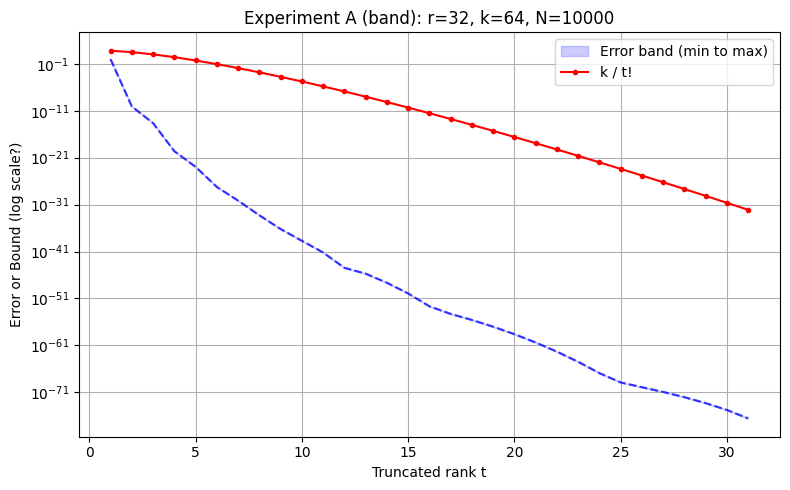

 11%|█▏        | 1131/10000 [00:09<01:12, 122.52it/s]


KeyboardInterrupt: 

In [16]:
from tqdm import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt

def newton_girard_predict(traces, k):
    r_eff = len(traces)
    if k <= r_eff:
        return traces[k-1]
    sums = [0]*(k+1)
    sums[0] = 1.0
    for i in range(1, r_eff+1):
        sums[i] = traces[i-1]
    a = [0]*(r_eff+1)
    a[0] = 1.0
    a[1] = sums[1]
    for i in range(2, r_eff+1):
        temp = 0.0
        for j in range(1, i+1):
            temp += ((-1)**(j-1)) * a[i-j] * sums[j]
        a[i] = temp / i
    for m in range(r_eff+1, k+1):
        tmp = 0.0
        for j in range(1, r_eff+1):
            tmp += ((-1)**(j-1)) * sums[m-j] * a[j]
        sums[m] = tmp
    return sums[k]

def experimentA_band(r=16, k_A=32, N=10000):
    """
    - r=16: rank for generating eigenvalues
    - k_A=32: the power we fix
    - N=1000: number of random trials
    
    We'll vary t in 1..(r-1).
    For each t, we'll gather all errors across N runs, then track min and max.
    We'll also compute the bound = k_A / t!.
    """
    t_vals = range(1, r)  # 1..15
    # We'll store min and max in arrays of length (r-1)
    min_errors = np.full((r-1,), np.inf)
    max_errors = np.zeros((r-1,))
    
    # We'll also store the bound in a separate array
    bounds = np.zeros((r-1,))
    
    # Precompute factorial for each t
    factorials = [math.factorial(t) for t in t_vals]
    
    for trial in tqdm(range(N)):
        # Generate random eigenvalues
        eigs = gen_almost_one(r)
        # Full (true) traces
        full_traces = [np.sum(eigs**i) for i in range(1, r+1)]
        # The "true" Tr(rho^k_A)
        P_k_full = newton_girard_predict(full_traces, k_A)
        
        for i, t in enumerate(t_vals):
            truncated_traces = full_traces[:t]
            P_k_trunc = newton_girard_predict(truncated_traces, k_A)
            err = abs(P_k_full - P_k_trunc)
            # Update min and max
            if err < min_errors[i]:
                min_errors[i] = err
            if err > max_errors[i]:
                max_errors[i] = err
    
    # Compute the bound array: bounds[i] = k_A / t!
    for i, t in enumerate(t_vals):
        bounds[i] = k_A / factorials[i]
    
    # Now we can plot the band
    plt.figure(figsize=(8,5))
    plt.fill_between(t_vals, min_errors, max_errors, color='blue', alpha=0.2,
                     label="Error band (min to max)")
    # We can also plot the min and max lines if we like:
    plt.plot(t_vals, min_errors, 'b--', alpha=0.5)
    plt.plot(t_vals, max_errors, 'b--', alpha=0.5)
    
    # Plot the bound
    plt.plot(t_vals, bounds, 'r.-', label="k / t!")
    
    plt.xlabel("Truncated rank t")
    plt.ylabel("Error or Bound (log scale?)")
    plt.yscale('log')
    plt.title(f"Experiment A (band): r={r}, k={k_A}, N={N}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def experimentB_band(r=16, t=8, k_start=17, k_end=64, N=10000):
    k_vals = range(k_start, k_end+1)
    min_errors = np.full((len(k_vals),), np.inf)
    max_errors = np.zeros((len(k_vals),))
    
    fac_t = math.factorial(t)
    
    for trial in tqdm(range(N)):
        eigs = gen_almost_one(r)
        full_traces = [np.sum(eigs**i) for i in range(1, r+1)]
        
        for i, k_ in enumerate(k_vals):
            P_k_full = newton_girard_predict(full_traces, k_)
            truncated_traces = full_traces[:t]
            P_k_trunc = newton_girard_predict(truncated_traces, k_)
            err = abs(P_k_full - P_k_trunc)
            if err < min_errors[i]:
                min_errors[i] = err
            if err > max_errors[i]:
                max_errors[i] = err
    
    bounds = [k_ / fac_t for k_ in k_vals]
    
    plt.figure(figsize=(8,5))
    plt.fill_between(k_vals, min_errors, max_errors, color='blue', alpha=0.2,
                     label="Error band (min to max)")
    plt.plot(k_vals, min_errors, 'b--', alpha=0.5)
    plt.plot(k_vals, max_errors, 'b--', alpha=0.5)
    
    plt.plot(k_vals, bounds, 'r.-', label="k / t!")
    plt.yscale('log')
    plt.xlabel("k")
    plt.ylabel("Error or Bound (log scale?)")
    plt.title(f"Experiment B (band): r={r}, t={t}, k={k_start}..{k_end}, N={N}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
experimentA_band(r=32, k_A=64, N=10000)
experimentB_band(r=16, t=8, k_start=17, k_end=64, N=10000)